# Mosquito Sinks and Sources Detection

# Setup

In [4]:
# Scientific Libraries
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn.cluster import KMeans

# Matplot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# GeoPandas
# !pip install descartes
# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Folium
# !pip install folium
import folium
import folium.plugins

In [5]:
transitions = pd.read_csv('kernel_regular_5000.csv', header=None)
locations = pd.read_csv('stp_all_sites_v3.csv')

# A Peak at the Data

In [6]:
display(transitions.shape, transitions.head())

(509, 509)

,0,1,2,3,4,5,6,7,8,9,...,499,500,501,502,503,504,505,506,507,508
0,0.7980,0.0060,0.0050,0.0035,0.0075,0.0010,0.0030,0.0030,0.0010,0.0010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0060,0.7465,0.0145,0.0120,0.0070,0.0035,0.0035,0.0055,0.0030,0.0050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0050,0.0145,0.7540,0.0160,0.0070,0.0040,0.0045,0.0070,0.0015,0.0035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0035,0.0120,0.0160,0.7705,0.0035,0.0060,0.0035,0.0025,0.0045,0.0035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0075,0.0070,0.0070,0.0035,0.7535,0.0035,0.0040,0.0015,0.0035,0.0060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
transitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Columns: 509 entries, 0 to 508
dtypes: float64(506), int64(3)
memory usage: 2.0 MB


In [8]:
display(locations.shape, locations.head())

(509, 3)

,lon,lat,pop
0,7.42917,1.61930,222
1,7.41421,1.63409,12
2,7.41390,1.63602,8
3,7.41219,1.63492,16
4,7.42591,1.64041,23


In [9]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     509 non-null    float64
 1   lat     509 non-null    float64
 2   pop     509 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 12.1 KB


# Clustering

In [10]:
def get_communities(transitions, locations, method='kmeans', *args, **kwargs):
    """
    Returns a dictionary where the key is the community id and the value is a
    list of locations grouped together using the kmeans algorithm. More 
    clustering methods may be added using the `method` parameter.
    """
    if method == 'kmeans':
        kmeans = KMeans(*args, **kwargs).fit(locations[['lon', 'lat']])
        communities = defaultdict(list)
        for loc, cid in enumerate(kmeans.labels_):
            communities[cid].append(loc)
        return communities
    else:
        raise ValueError("Method '{}' is not supported".format(method))

# Computing the Migration Matrix 

In [11]:
def migrate(transitions, locations, steps=1):
    """
    Returns the populations of each location after `steps` time steps.
    """
    return np.linalg.matrix_power(transitions, steps) @ locations['pop']

# Calculating the In/Out Ratios and Classifying each Community

In [131]:
def classify(prop_in, prop_out, eps=1e-5):
    """
    Returns whether a community is a sink, source, or bridge.
    """
    diff = prop_in - prop_out
    if abs(diff) < eps: return 'bridge'
    if diff < 0:        return 'source'
    if diff > 0:        return 'sink'

def get_proportions(transitions, locations, communities, start_step=0, final_step=1):
    """
    Returns a dictionary such that each key is a community id and each value is a dictionary. In the
    second-level dictionary, there are 5 keys which are explained in depth below:
        1. num_in  -> number of mosquitos that migrated into this community since time step `start_step`
        2. num_out -> number of mosquitos that migrated out of this community since time step `start_step`
        3. prp_in  -> the proportion of mosquitos that entered the community since time step `start_step`
        4. prp_out -> the proportion of mosquitos that left the community since time step `start_step`
        5. type    -> either source, sink, or bridge
    """
    flows = defaultdict(dict)
    for cid, community in communities.items():
        start = migrate(transitions, locations, start_step)[community]
        final = migrate(transitions, locations, final_step)[community]
        flows[cid]['num_in']  = np.sum(final[final > start] - start[final > start])
        flows[cid]['num_out'] = np.sum(start[final < start] - final[final < start])
        flows[cid]['prp_in']  = flows[cid]['num_in']  / (flows[cid]['num_in'] + flows[cid]['num_out'])
        flows[cid]['prp_out'] = flows[cid]['num_out'] / (flows[cid]['num_in'] + flows[cid]['num_out'])
        flows[cid]['type']    = classify(flows[cid]['prp_in'], flows[cid]['prp_out'])
    return flows

# Sanity Check

In [132]:
communities = get_communities(transitions, locations, n_clusters=4, random_state=0)
proportions = get_proportions(transitions, locations, communities, 0, 3000)
for k1 in sorted(proportions):
    print("Cid:", k1)
    for k2 in proportions[k1]:
        print(k2 + ":", proportions[k1][k2])
    print()

Cid: 0
num_in: 58242.38944930337
num_out: 77529.52475889042
prp_in: 0.4289722936364734
prp_out: 0.5710277063635267
type: source

Cid: 1
num_in: 3219.566037736949
num_out: 3219.5660377333515
prp_in: 0.5000000000002793
prp_out: 0.4999999999997206
type: bridge

Cid: 2
num_in: 14450.732892297368
num_out: 1762.2347993486458
prp_in: 0.8913070800568692
prp_out: 0.10869291994313077
type: sink

Cid: 3
num_in: 17486.78153667916
num_out: 10888.144320022364
prp_in: 0.6162758494943934
prp_out: 0.38372415050560665
type: sink



# Merging the Outputs into One Dictionary

In [14]:
def merge(communities, proportions):
    output = dict()
    for k in communities:
        output[k] = proportions[k]
        output[k]['community'] = communities[k]
    return output

merge(communities, proportions)[1]

{'num_in': 3219.566037736949,
 'num_out': 3219.5660377333515,
 'prp_in': 0.5000000000002793,
 'prp_out': 0.4999999999997206,
 'type': 'bridge',
 'community': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52]}

# Plots

### First, let's see where the data is geographically:

In [15]:
COORDS = (7.42917, 1.61930)
folimp = folium.Map(locations=COORDS, zoom_start=13)
points = locations[['lat', 'lon']].astype('float').values
heatmp = folium.plugins.HeatMap(points.tolist(), radius=10)
folimp.add_child(heatmp)

In [16]:
cluster = folium.plugins.MarkerCluster()
for _, r in locations[['lat', 'lon']].iterrows():
    cluster.add_child(folium.Marker([float(r['lat']), float(r['lon'])]))
folimp = folium.Map(locations=COORDS, zoom_start=13)
folimp.add_child(cluster)
folimp

### Next, let's see how the communities were clustered:

In [79]:
# This creates a new table where each location in locations is
# assigned to their community id
with_cid = pd.DataFrame({'cid' : list(range(locations.shape[0]))})
for cid in communities:
    with_cid.loc[communities[cid]] = cid
with_cid = locations.merge(with_cid, left_index=True, right_index=True)
with_cid.head()

,lon,lat,pop,cid
0,7.42917,1.61930,222,1
1,7.41421,1.63409,12,1
2,7.41390,1.63602,8,1
3,7.41219,1.63492,16,1
4,7.42591,1.64041,23,1


In [118]:
def plot_colored_scatter(coordinate_df, color_col='cid', title='Colored Scatter Plot', xlims=None, ylims=None):
    """
    Returns a geographic scatter plot. The required parameter, 
    coordinate_df, must consist of the following columns:
        1. lon
        2. lat
        3. cid
    """
    # Set up the plots
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title, fontsize=15,fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot geo map
    geo_map = gpd.read_file('geo/STP_admbndp1_1m_gadm.shp')
    geo_map.to_crs(epsg=4326)
    geo_map.plot(ax=ax, alpha=0.4, color='black')

    # Plot data points over map
    geometry = [Point(xy) for xy in zip(coordinate_df['lon'], coordinate_df['lat'])]
    geo_df = gpd.GeoDataFrame(coordinate_df, geometry=geometry)
    geo_df.plot(column=color_col, ax=ax, alpha=0.5, legend=True, markersize=10)

    # Show visualization
    if xlims is not None: plt.xlim(*xlims)
    if ylims is not None: plt.ylim(*ylims)
    plt.show()

In [119]:
# In the previous section, we saw that there are two islands that
# are independent of each other. Let's split them up:
principe_locs = with_cid[with_cid['lat'] > 1.25]
principe_tmtx = transitions.iloc[principe_locs.index, principe_locs.index]
sao_tome_locs = with_cid[with_cid['lat'] < 0.50]
sao_tome_tmtx = transitions.iloc[sao_tome_locs.index, sao_tome_locs.index]

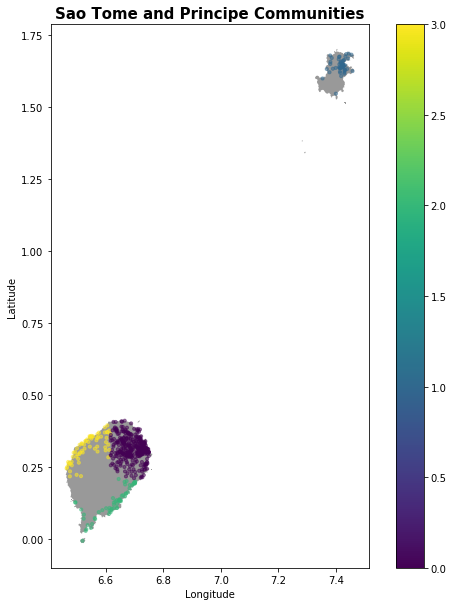

In [193]:
plot_colored_scatter(with_cid, title='Sao Tome and Principe Communities')

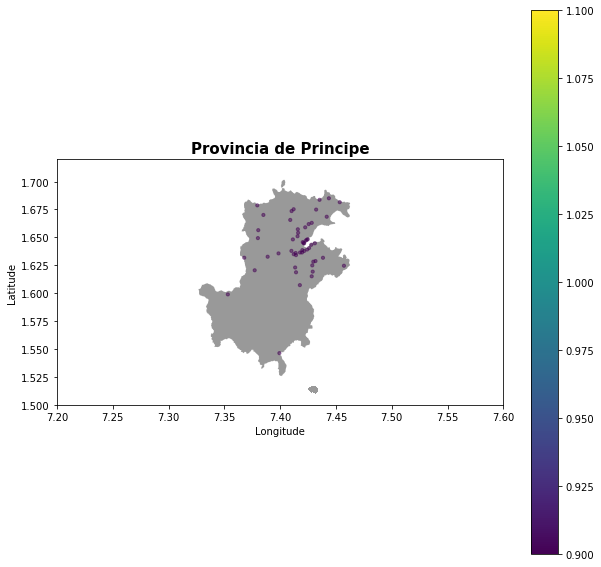

In [120]:
plot_colored_scatter(principe_locs, title='Provincia de Principe', xlims=(7.2, 7.6), ylims=(1.5, 1.72))

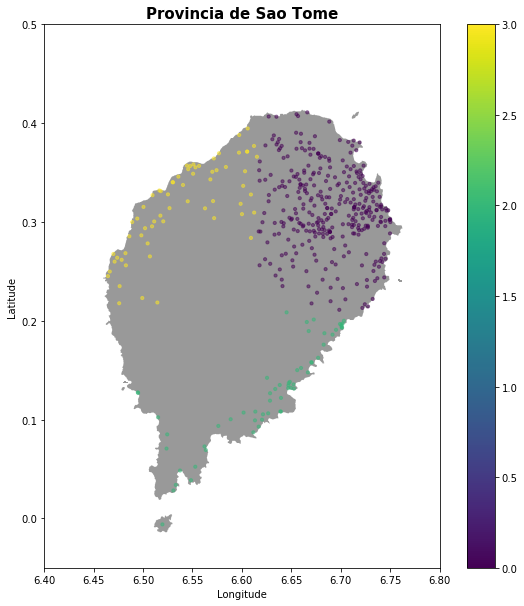

In [121]:
plot_colored_scatter(sao_tome_locs, title='Provincia de Sao Tome', xlims=(6.4, 6.8), ylims=(-0.05, 0.5))

### Now let's use a graph to visualize the connections:

In [344]:
def plot_network(tmtx, locs):
    """
    Plots a network of the nodes. The `locs` parameter must consist
    of the following columns:
        1. lon
        2. lat
        3. cid
    """
    # Set up the graph
    G = nx.from_numpy_matrix(tmtx.values)
    nodes = { i : (x, y) for i, x, y in zip(np.arange(locs.shape[0]), locs['lon'], locs['lat']) }
    edges = [w for n1, n2, w in G.edges.data('weight')]
    nx.set_node_attributes(G, pos, 'pos')
    
    # Plot
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_edges(G, nodes,
                           edge_color=np.arange(len(edges)),
                           cmap=cm.binary, 
                           alpha=0.4)
    nx.draw_networkx_nodes(G, nodes,
                           node_size=80,
                           nodelist=np.arange(locs.shape[0]),
                           node_color=locs['cid'].values,
                           cmap=cm.autumn)
    plt.axis('off')
    plt.show()

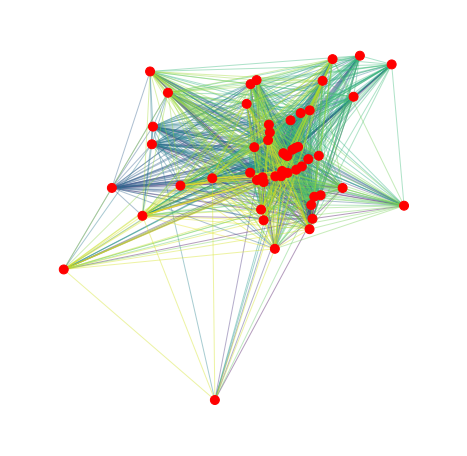

In [345]:
plot_network(principe_tmtx, principe_locs)

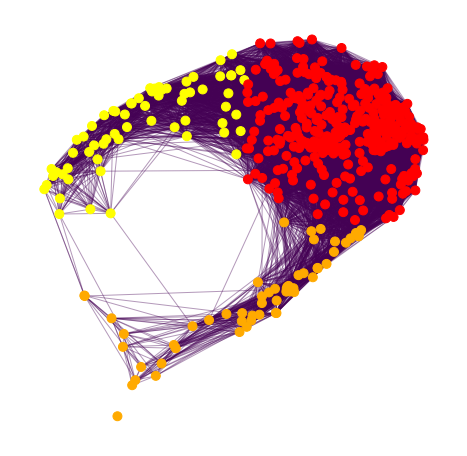

In [331]:
plot_network(sao_tome_tmtx, sao_tome_locs)

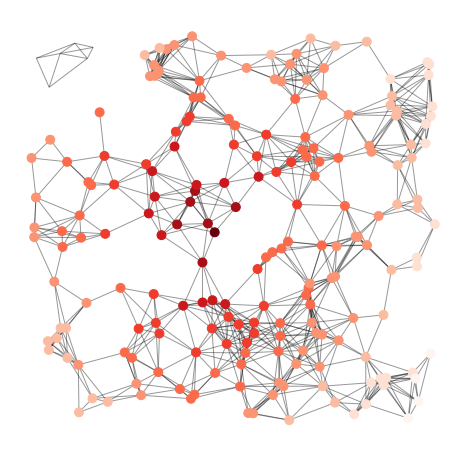

In [325]:
#https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html#sphx-glr-auto-examples-drawing-plot-random-geometric-graph-py

G = nx.random_geometric_graph(200, 0.125)

# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, 'pos')

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()